# Supervised Learning Final Project: Aurora, CO Weather

## Project Overview

### Project Topic

The Front Range of Colorado, on the eastern side of the Rocky Mountains, has a dry climate with relatively little precipitation. As such, it is useful to know ahead of time when it will rain, to make proper preparations for the day ahead.

Plus it would be fun to look out the window and validate/invalidate my results.

In this project, I will be using weather data collected in Aurora, Colorado, United States to predict whether the next day will have precipitation. The data was collected and released into the public domain by the National Renewable Energy Laboratory (NREL); full citation is available at the end of this notebook. I will use the supervised learning algorithms random forest decision trees and logistic regression to classify days into "precipitation" or "no precipitation". If feasible, I plan to also perform multilinear regression to predict how much precipitation will fall.

## Data Overview

The weather data is provided in a single tabulated form, size 172.0 kB. It contains 1,956,230 samples of 20 features, collected every minute from February 11, 2011 to October 31, 2014. The features are as follows (descriptions are taken directly from provided metadata):

* date (str)
    * The date and time the data was recorded ( eg 02/20/2010 10:01)
* globalhorizontal (float64)
    * Total Hemispheric shortwave irradiance as measured by an Kipp & Zonen Model CMP22 with calibration factor traceable to the World Radiometric Reference (WRR), measured in W/m2
* directnormal (float64)
    * Direct (Beam) shortwave irradiance as measured by a Kipp & Zonen Model CH1 mounted in an automatic sun-following tracker (Model 2AP) with calibration factor traceable to the World Radiometric Reference (WRR), measured in W/m2
* diffusehorizontal (float64)
    * Diffuse (Sky) shortwave irradiance, measured in W/m2
* airtemperature (float64)
    * The air temperature, measured in degrees Celsius
* stationpressure (float64)
    * The barometric pressure at the station, measured in mBar
* avgwindspeed10m (float64)
    * The average wind speed over that minute, measured at 10 meters in m/s
* avgwinddirection10m (float64)
    * The average wind direction over that minute, measured at 10 meters in degrees from north
* avgwinddirectionstddev10m (float64)
    * The standard deviation of the wind direction, in m/s
* avgwindspeedstddev10m (float64)
    * The standard deviation of the wind speed, in m/s
* winddirectionpkws (float64)
    * The highest value of wind speed over that minute, in m/s
* windchilltemp (float64)
    * The wind chill temperature, measured in degrees Celsius
* dewpointtemp (float64)
    * The dew point temperature, measured in degrees Celsius
* zenithangle (float64)
    * Solar zenith angle (refracted), measured in degrees
* azimuthangle (float64)
    * Solar azimuth angle, measured in degrees
* relhumidity (float64)
    * The relative humidity, as a percentage (eg 86.3)
* precipitation (float64)
    * The amount of precipitation to fall during that minute, measured in mm
* precipitationaccumulated (float64)
    * The amount of precipitation to fall during that day up to that minute, measured in mm
* airmass (float64)
    * Relative optical airmass (not pressure corrected)

## Data Exploration and Cleaning

### Notebook Setup

In [1]:
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [2]:
# Import data
data = pd.read_csv('Weather_Station_in_Aurora_Colorado_2014.csv')

### Data Cleaning and Exploratory Data Analysis

I will not be using the standard deviation data. It would be good for developing a formal model but complicates the analysis for this project. I am also not keeping airmass data - by my understanding, this is essentially a proxy for solar angle, which I already have information on via zenith/azimuth angles, time, and date, given that all data was collected at one location. I will drop those columns now.

In [3]:
data.drop(columns=['avgwinddirectionstddev10m','avgwindspeedstddev10m','airmass'],inplace=True)

#### Missing Values

Some data values are missing, replaced with NaN or the placeholder value -99999.0. Notably, several columns begin with a long series of missing values as the data was either not collected or not saved into this dataset.
* Irradiance data (globalhorizontal, directnormal, diffusehorizontal) is not included before row 51.
* Precipitation data (precipitation, precipitationaccumulated) is not included before row 154.
* Peak wind speed direction is not included before row 216069.

I will test the correlation between peak wind speed direction and average wind speed direction to see if using just the average direction would be a good replacement for both average and peak:

In [4]:
# Correlation between peak wind speed direction and average wind speed direction
# Quick and dirty cleaning for calculation
wind_dir = data.loc[:,['winddirectionpkws','avgwinddirection10m']]
wind_dir.loc[wind_dir['winddirectionpkws'] == -99999.0,:] = np.nan
wind_dir.dropna(how='any',inplace=True)

pearsonr(wind_dir['winddirectionpkws'],wind_dir['avgwinddirection10m'])

PearsonRResult(statistic=0.7979190856436081, pvalue=0.0)

I will drop peak wind speed direction, as this is highly correlated with average wind speed direction (Pearson correlation coefficient = 0.80).

In [5]:
data.drop(columns=['winddirectionpkws'],inplace=True)

My feature of interest, precipitation, does not appear in the data until row 154. Luckily, this is a negligible amount compared to the nearly two million total rows. In particular, row 154 is associated with 2:13 pm on February 11, 2011. This is within the first day of data collection.

Since my analysis will be looking day-over-day, I will trim the data to full days' worth of collection. This involves removing entries from February 11, 2011 (where data starts at 12:20 pm) and October 31, 2014 (where data ends at 11:51 pm). This removes the initial missing values of precipitation (as well as irradiance).

In [6]:
data.drop(data.index[data['date'].str.contains('02/11/2011') | data['date'].str.contains('10/31/2014')],inplace=True)

The above steps have removed all NaN values in the dataset. However, there are still -99999.0 values in the irradiance columns. These (globalhorizontal, directnormal, diffusehorizontal) columns only have a few missing values (18, 54, and 19, respectively). I will impute these to the column average.

In [7]:
for i in ['globalhorizontal','directnormal','diffusehorizontal']:
    avg = data[data[i] != -99999.0][i].mean()
    data.loc[data[i] == -99999.0, i] = avg

#### Outlier Check

I'm checking box-and-whisker plots of all numerical variables to check for outliers. Individual plots can be found in the "Boxplots" folder in the github repository.

<AxesSubplot: >

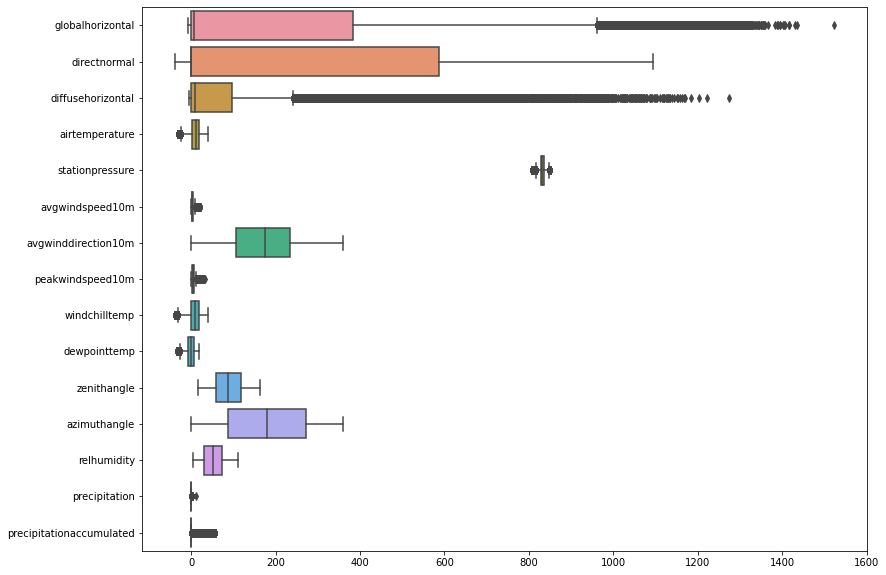

In [8]:
plt.figure(figsize=(13,10))
sns.boxplot(data,orient='h')

In [9]:
# Generating all boxplots as image files
for col in data.columns:
    if col == 'date':
        continue
    f = plt.figure()
    sns.boxplot(data.loc[:,[col]],orient='h')
    plt.savefig('Distribution Plots/'+col+'.png',bbox_inches='tight',facecolor='white', transparent=False)
    plt.close(f)

Most features have data points flagged as outliers by the box-and-whiskers calculation. Several appear to be very long-tailed distributions, such as the irradiance data, and as such, I will keep all the data points from these. I will investigate the following features more closely: <br>
* precipitation
* precipitationaccumulated

Percent of precipitation data = 0:  0.9974217742880581
Maximum precipitation value:  11.18


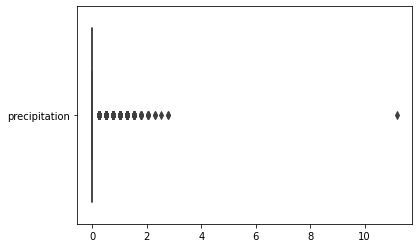

In [10]:
sns.boxplot(data.loc[:,['precipitation']],orient='h')
print("Percent of precipitation data = 0: ",sum(data['precipitation']==0)/data['precipitation'].shape[0])
print("Maximum precipitation value: ",max(data['precipitation']))

Percent of precipitationaccumulated data = 0:  0.8780649694456201
Maximum precipitation accumulated value:  56.64


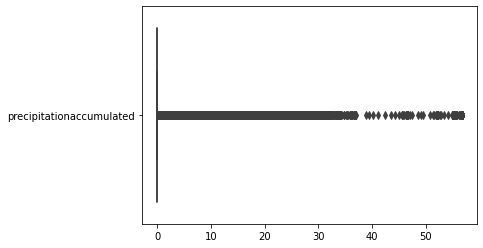

In [11]:
sns.boxplot(data.loc[:,['precipitationaccumulated']],orient='h')
print("Percent of precipitationaccumulated data = 0: ",
      sum(data['precipitationaccumulated']==0)/data['precipitationaccumulated'].shape[0])
print("Maximum precipitation accumulated value: ",max(data['precipitationaccumulated']))

The precipitation and precipitationaccumulated data are both highly imbalanced, with 99.7% and 87.8% of the data being zero, respectively. This is consistent with the dry climate of Aurora. Looking at the high end of the outliers, the data is showing max values of precipitation at 11 mm in one minute, which is a reasonable, if unusual, value for a Colorado cloudburst; and 57 mm in one day, which is actually lower than expected given that this time range includes the extreme rainfall of September 2013. I will keep all values for these features.

The imbalance I will need to account for during the modeling stage. With it being so extreme, I anticipate regression will not be very effective. I may do a brief test to see how a multilinear regression behaves on this dataset, but I will focus on classification of precipitation/no precipitation.

#### Data Type Munging

The date column is currently a string. This will be more useful as a datetime object. As I plan to analyze by day instead of by minute or hour, I will also convert the 'date' column to only have the day information, saving the full datetime information for a 'datetime' column.

I am also breaking out columns for year and month, so I can potentially track cyclical patterns.

In [12]:
data['datetime'] = pd.to_datetime(data.loc[:,'date'],format='%m/%d/%Y %I:%M:%S %p')
data['date'] = data['datetime'].dt.date
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month

#### Data Aggregation

Before I offset my precipitation data to the day before, I want to aggregate the data by day, which should provide better results than trying to predict minute-by-minute whether there will be rain.

Precipitation is already aggregated by day as precipitationaccumulated - I will lose the time-based data on when and at what rate there was precipitation, but that's beyond the scope of this project. I will drop the precipitation column.

In [13]:
data.drop(columns=['precipitation'],inplace=True)

The remainder of the columns, I need to decide how to aggregate. (Ideally, I would consult with a domain expert, but this is currently unavailable.) I would like to keep interpretability, as stated above, to focus on the most critical measurable features, so I will not be using PCA or similar dimensionality reduction techniques. My goal is to preserve as much variation in the features as possible while reducing to one data point per day, in a consistent manner across days. I will test four basic statistical measures and see which maintains the most variance.

In [14]:
# Test max, min, mean, and median as measures
test_aggs = data.groupby(['date']).agg(['max','min','mean','median'])
test_aggs_var = test_aggs.var(numeric_only=True)

In [15]:
# Collect method with highest variance
agg_columns = data.columns.drop(['date','datetime'])
agg_metric_val = []
best_agg_metric = []

for col in agg_columns:
    max_val = test_aggs_var[col].max()
    best_agg = test_aggs_var[col][test_aggs_var[col]==max_val].index[0]
    agg_metric_val.append(max_val)
    best_agg_metric.append(best_agg)

agg_metrics = pd.DataFrame([agg_columns,best_agg_metric,agg_metric_val]).T

In [16]:
# Printing best method for each column, along with resulting variance
agg_metrics

,0,1,2
0,globalhorizontal,max,64057.681777
1,directnormal,max,47618.664727
2,diffusehorizontal,max,34842.672825
3,airtemperature,max,119.040043
4,stationpressure,min,34.968087
5,avgwindspeed10m,max,10.620325
6,avgwinddirection10m,median,3129.342156
7,peakwindspeed10m,max,18.281281
8,windchilltemp,min,146.247329
9,dewpointtemp,min,63.765399


In [17]:
# Update dataframe using chosen aggregate methods
agg_metrics_dict = agg_metrics.loc[:,1].rename(index=agg_metrics[0])
agg_metrics_dict = agg_metrics_dict.to_dict()

data = data.groupby(['date']).agg(agg_metrics_dict)

The final step in data preparation is shifting the precipitationaccumulated data back a day, so it can be associated with the previous day's measurements. I do lose the last day's data here by doing so, so that my new range is data from 2/12/2011 to 10/29/2014, predicting precipitation for 2/13/2011 to 10/30/2014. I am also adding a column converting this to a binary "precipitation or no precipitation", as my focus has shifted to classification.

In [18]:
data['tomorrows_precipitation'] = data['precipitationaccumulated'].shift(-1)
data.dropna(inplace=True)
data['tomorrows_precip_binary'] = (data['tomorrows_precipitation'] > 0)

In [19]:
# Split data into X and y
X_data = data.loc[:,data.columns.drop(['tomorrows_precipitation','tomorrows_precip_binary'])]
y_data = data.loc[:,['tomorrows_precip_binary']]

#### Correlation matrix

I am doing an initial look at the correlations between my variables.

<AxesSubplot: >

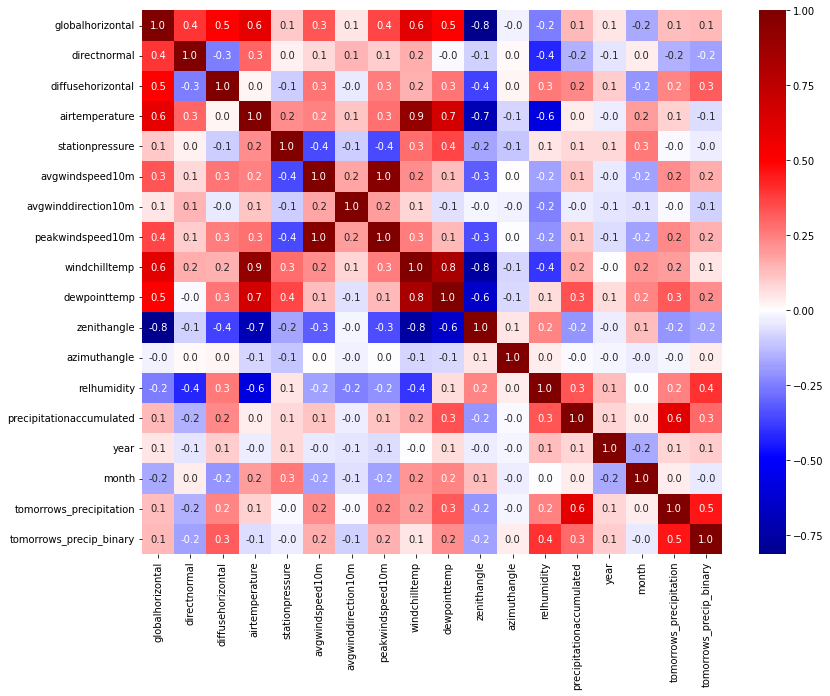

In [20]:
corr = data.corr(numeric_only=True)
plt.figure(figsize=(13,10))
sns.heatmap(corr,center=0,cmap='seismic',annot=True,fmt='.1f')

There are several strong correlations between variables that I will need to consider in the modeling stage. I may end up not using some features that are correlated and are similar measurements, e.g. peak wind speed vs average wind speed, or wind chill temperature vs air temperature.

## Modeling

For modeling, I am testing out two classification methods - random forest and logistic regression. These are both well-suited to binary data with many features. I will be checking metrics after each model iteration to determine if I should do further tweaking, but will save full analysis for the analysis section.

I am prepping the data for modeling by splitting into training and testing sets and scaling the data (separately, so as not to introduce future knowledge to the training set). I am also creating a copy of the training set that has been resampled via SMOTE, to see if oversampling my highly imbalanced data improves the performance.

In [21]:
def data_setup(X_data,y_data,seed=2023):
    # Reproducibility
    np.random.seed(seed)
    
    # Breaking into train/test datasets
    X_train, X_test, y_train, y_test = train_test_split(X_data,y_data)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    # Scaling data
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit(X_train).transform(X_train),columns=X_data.columns)
    X_test = pd.DataFrame(scaler.fit(X_test).transform(X_test),columns=X_data.columns)
    
    # Balancing data with SMOTE
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X_train,y_train)
    
    return X_train,y_train, X_res,y_res, X_test,y_test

In [22]:
# Setting up metric printout
def calc_metrics(name,y_true,y_pred,target_label=True):
    precision,recall,fscore,support = metrics.precision_recall_fscore_support(y_true,y_pred,
                                                                              pos_label=target_label,
                                                                              average='binary')
    print(name)
    print(pd.DataFrame([np.round([fscore,recall,precision],decimals=2)],
                       columns=['F1','Recall','Precision'],index=['']))

I am fitting a random forest model, then adjusting with SMOTE-resampled data, feature selection, and tuning. For hyperparameter tuning, I am choosing random values of a few hyperparameters at first; if this increases performance from the untuned data, I will perform more specific tuning.

In [23]:
# Random Forest
# Default classifier
rf_X_train, rf_y_train, rf_X_res, rf_y_res, rf_X_test, rf_y_test = data_setup(X_data, y_data)
rf_model = RandomForestClassifier().fit(rf_X_train,rf_y_train)
rf_pred = rf_model.predict(rf_X_test)
calc_metrics('Random Forest - Untuned, Unbalanced',rf_y_test,rf_pred)

Random Forest - Untuned, Unbalanced
    F1  Recall  Precision
  0.71    0.64       0.79


In [24]:
# Trying out SMOTE
rf_sm = RandomForestClassifier().fit(rf_X_res,rf_y_res)
rf_sm_pred = rf_sm.predict(rf_X_test)
calc_metrics('Random Forest - Untuned, SMOTE-balanced',rf_y_test,rf_sm_pred)

Random Forest - Untuned, SMOTE-balanced
    F1  Recall  Precision
  0.72    0.69       0.75


SMOTE resampling did improve performance on F1 and recall metrics! I am less interested in precision, as I am more interested in predicting rain if there is rain, aka recall. I will be using the resampled data going forward on random forest. I'm now going to look at feature importances, to see if I can optimize what features I'm training on.

In [25]:
# Feature selection
feature_importances = pd.DataFrame(rf_sm.feature_importances_,
                                   index=X_data.columns,
                                   columns=['Importance']).sort_values(by='Importance',ascending=False)
feature_importances

,Importance
precipitationaccumulated,0.199493
relhumidity,0.122841
diffusehorizontal,0.084188
dewpointtemp,0.065418
directnormal,0.059343
globalhorizontal,0.055505
stationpressure,0.053344
airtemperature,0.050597
zenithangle,0.048228
avgwindspeed10m,0.046341


There does not appear to be any features that are overwhelmingly important or unimportant, except month and year. I do have collinearity issues that may be impacting feature importance, however. From my earlier correlation matrix, my strongest cross-feature correlations are:
* Wind speed
    * Peak wind speed / Average wind speed
* Temperature
    * Air temperature / Wind chill temperature
    * Dew point temperature / Wind chill temperature
    * Dew point temperature / Air temperature
* Zenith angle
    * Zenith angle / Global horizontal
    * Zenith angle / Wind chill temperature
    * Zenith angle / Air temperature
    
I expect dropping peak wind speed, wind chill and dew point temperatures, and zenith angle measurements will give more clarity in my feature rankings, as they will no longer be split among similar features.

In [26]:
# Creating copy of data
for col in ['peakwindspeed10m','windchilltemp','dewpointtemp','zenithangle']:
    rf_X_res = rf_X_res.loc[:,rf_X_res.columns.drop([col])]
    rf_X_test = rf_X_test.loc[:,rf_X_test.columns.drop([col])]
    
    clf = RandomForestClassifier().fit(rf_X_res,rf_y_res)
    feature_importances = pd.DataFrame(clf.feature_importances_,
                                       index=rf_X_res.columns,
                                       columns=[col]).sort_values(by=col,ascending=False)
    print(feature_importances)

                          peakwindspeed10m
precipitationaccumulated          0.187722
relhumidity                       0.110610
diffusehorizontal                 0.086182
dewpointtemp                      0.074355
directnormal                      0.064532
airtemperature                    0.064448
stationpressure                   0.061355
globalhorizontal                  0.058406
zenithangle                       0.051128
avgwindspeed10m                   0.050977
avgwinddirection10m               0.049826
windchilltemp                     0.048524
azimuthangle                      0.045287
month                             0.024400
year                              0.022249
                          windchilltemp
precipitationaccumulated       0.188915
relhumidity                    0.120568
diffusehorizontal              0.090241
directnormal                   0.074122
dewpointtemp                   0.073776
stationpressure                0.066017
airtemperature                 0

Dropping these four columns has improved my feature rankings, and checking correlations between the remaining variables (below) shows the maximum correlations are now around 0.6. I will drop month and year, as they only account for 5% of the feature importance, and refit my model.

<AxesSubplot: >

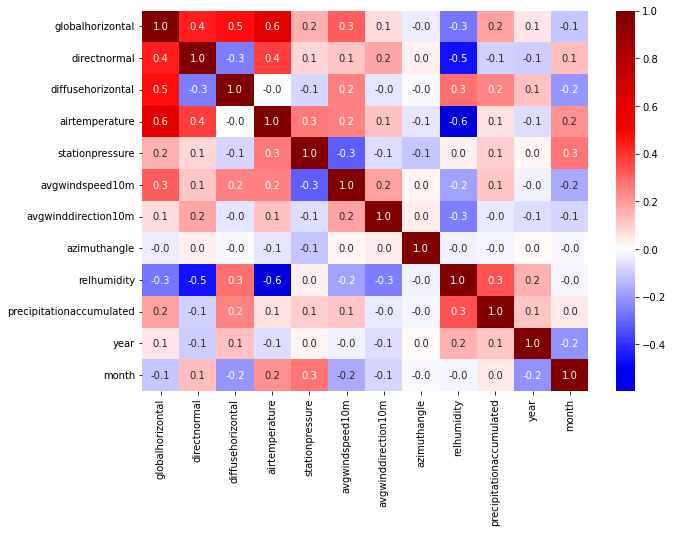

In [27]:
corr = rf_X_res.corr(numeric_only=True)
plt.figure(figsize=(10,7))
sns.heatmap(corr,center=0,cmap='seismic',annot=True,fmt='.1f')

In [28]:
rf_X_res = rf_X_res.loc[:,rf_X_res.columns.drop(['month','year'])]
rf_X_test = rf_X_test.loc[:,rf_X_test.columns.drop(['month','year'])]

rf = RandomForestClassifier().fit(rf_X_res,rf_y_res)
rf_pred = rf.predict(rf_X_test)
calc_metrics('Random Forest - Untuned, SMOTE-balanced, Feature Selected',rf_y_test,rf_pred)

Random Forest - Untuned, SMOTE-balanced, Feature Selected
    F1  Recall  Precision
  0.74    0.72       0.77


This is an improvement over no feature selection. Now I will try tuning some of the hyperparameters of the model to see if that further increases performance. I will start by using RandomizedSearchCV.

In [29]:
# Hyperparameter tuning
clf = RandomForestClassifier()
max_depth = [int(x) for x in np.linspace(start=5,stop=100,num=10)]
max_depth.append(None)
parameters = {'n_estimators': [int(x) for x in np.linspace(start=10,stop=1000,num=10)],
              'max_depth': max_depth,
              'min_samples_split': [int(x) for x in np.linspace(start=2,stop=20,num=5)],
              'min_impurity_decrease': [x for x in np.linspace(start=0,stop=10,num=10)],
              'class_weight': [None,'balanced','balanced_subsample']
              }

In [30]:
rf_random = RandomizedSearchCV(clf,parameters,n_iter=100,scoring='f1',cv=3).fit(rf_X_res,rf_y_res)
print(rf_random.best_params_)
rf_random_pred = rf_random.predict(rf_X_test)
calc_metrics('Random Forest - Random Tuning, SMOTE-balanced, Feature Selected',rf_y_test,rf_random_pred)

{'n_estimators': 890, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 'max_depth': 47, 'class_weight': 'balanced_subsample'}
Random Forest - Random Tuning, SMOTE-balanced, Feature Selected
    F1  Recall  Precision
  0.75    0.71       0.79


Hyperparameter tuning did not result in an increase in performance, so I will not perform further tuning. I will use the untuned model for later analysis.

I am also fitting a logistic regression model, first on the scaled original data and then on the resampled data. I am also doing some slight hyperparameter tuning of unweighted vs frequency-weighted data.

In [31]:
# Logistic Regression
lr_X_train,lr_y_train, lr_X_res,lr_y_res, lr_X_test,lr_y_test = data_setup(X_data,y_data)

clf = LogisticRegression(max_iter=1000)
parameters = {'class_weight': (None,'balanced')}
clf_tuned = GridSearchCV(clf,parameters,scoring='f1')

lr = clf_tuned.fit(lr_X_train,lr_y_train)
print(lr.best_params_)
lr_pred = lr.predict(lr_X_test)

calc_metrics('Logistic Regression - Unbalanced',lr_y_test,lr_pred)

lr = clf_tuned.fit(lr_X_res,lr_y_res)
print(lr.best_params_)
lr_pred = lr.predict(lr_X_test)

calc_metrics('Logistic Regression - Balanced',lr_y_test,lr_pred)

{'class_weight': 'balanced'}
Logistic Regression - Unbalanced
    F1  Recall  Precision
  0.69    0.68       0.71
{'class_weight': None}
Logistic Regression - Balanced
   F1  Recall  Precision
  0.7    0.68       0.71


Balancing the data with SMOTE did not greatly improve performance on the logistic regression model. It does appear that using the in-built class weight option is better on unbalanced data, but unnecessary on SMOTE balanced data. I will test removing my four highly correlated variables.

In [32]:
lrsel_X_res = lr_X_res.loc[:,lr_X_res.columns.drop(['peakwindspeed10m','zenithangle',
                                                    'windchilltemp','dewpointtemp'])]
lrsel_X_test = lr_X_test.loc[:,lr_X_test.columns.drop(['peakwindspeed10m','zenithangle',
                                                       'windchilltemp','dewpointtemp'])]

lr_sel = clf_tuned.fit(lrsel_X_res,lr_y_res)
print(lr_sel.best_params_)
lr_sel_pred = lr_sel.predict(lrsel_X_test)

calc_metrics('Logistic Regression - Feature Selected',lr_y_test,lr_sel_pred)

{'class_weight': None}
Logistic Regression - Feature Selected
    F1  Recall  Precision
  0.68    0.67       0.68


Removing the correlated variables decreased performance. I will use the SMOTE balanced model, for what small boost it gives, and move on to analysis.

In [33]:
lr = clf_tuned.fit(lr_X_res,lr_y_res)

## Results and Analysis

<i>For grading, please note that the iteration process is in the Modeling section above.</i>

I am evaluating my best Random Forest and Logistic Regression models found in the previous section. I determined improvements by looking primarily at F1 and recall metrics - F1 tends to be a good evaluator of imbalanced data like mine, while recall specifically looks at my target of correctly predicting precipitation on days that do have precipitation. The following are the metrics from my two best models:

In [34]:
calc_metrics('Random Forest',rf_y_test,rf_pred)
calc_metrics('Logistic Regression',lr_y_test,lr_pred)

Random Forest
    F1  Recall  Precision
  0.74    0.72       0.77
Logistic Regression
   F1  Recall  Precision
  0.7    0.68       0.71


Both models perform better than a 50/50 coin toss on predicting rain. However, Random Forest out-performs Logistic Regression on F1, recall, and precision. It also has a data collection advantage in that it takes six fewer features than the Logistic Regression model.

I can break down the models' performance by plotting confusion matrices.

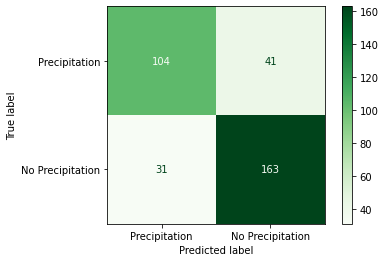

In [35]:
metrics.ConfusionMatrixDisplay.from_estimator(rf,rf_X_test,rf_y_test,cmap='Greens',labels=[True,False],
                                              display_labels=['Precipitation','No Precipitation'])

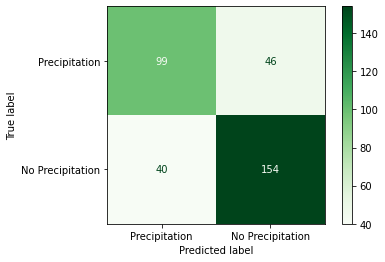

In [36]:
metrics.ConfusionMatrixDisplay.from_estimator(lr,lr_X_test,lr_y_test,cmap='Greens',labels=[True,False],
                                              display_labels=['Precipitation','No Precipitation'])

Random Forest again out-performs Logistic Regression in every category (true/false positive and true/false negative).

In [37]:
print('Random Forest Accuracy = ',np.round(metrics.accuracy_score(rf_y_test,rf_pred),decimals=2))
print('Logistic Regression Accuracy = ',np.round(metrics.accuracy_score(lr_y_test,lr_pred),decimals=2))

Random Forest Accuracy =  0.79
Logistic Regression Accuracy =  0.75


Accuracy is not the best metric for this project, given the imbalance in the data, but it's nice to see that Random Forest again out-performs Logistic Regression here.

Below, I am doing a quick rerun of the model fitting on different train/test data splits, to see how my chosen procedure works for different data than it was tuned on.

In [38]:
rf_X_data = X_data.loc[:,X_data.columns.drop(['peakwindspeed10m','zenithangle','windchilltemp',
                                              'dewpointtemp','month','year'])]

for i in [int(x) for x in np.linspace(0,100,num=5)]:
    rf_X_train,rf_y_train,rf_X_res,rf_y_res,rf_X_test,rf_y_test = data_setup(rf_X_data,y_data,seed=i)
    rf = RandomForestClassifier().fit(rf_X_res,rf_y_res)
    rf_pred = rf.predict(rf_X_test)
    calc_metrics('Random Forest',rf_y_test,rf_pred)
    
    X_train,y_train,X_res,y_res,X_test,y_test = data_setup(X_data,y_data,seed=i)
    lr = LogisticRegression().fit(X_res,y_res)
    lr_pred = lr.predict(X_test)
    calc_metrics('Logistic Regression',y_test,lr_pred)
    
    print("")

Random Forest
    F1  Recall  Precision
  0.59     0.8       0.47
Logistic Regression
   F1  Recall  Precision
  0.6    0.68       0.54

Random Forest
    F1  Recall  Precision
  0.71    0.76       0.66
Logistic Regression
   F1  Recall  Precision
  0.7    0.81       0.62

Random Forest
    F1  Recall  Precision
  0.61    0.89       0.47
Logistic Regression
    F1  Recall  Precision
  0.65     0.7        0.6

Random Forest
    F1  Recall  Precision
  0.68    0.63       0.73
Logistic Regression
    F1  Recall  Precision
  0.71    0.75       0.67

Random Forest
    F1  Recall  Precision
  0.68    0.67       0.69
Logistic Regression
   F1  Recall  Precision
  0.7    0.73       0.68



All recall values in this quick test are above 0.6 and usually closer to 0.7-0.8, which is heartening. However, it is a bit of a toss-up to whether Random Forest or Logistic Regression performs better, and their recall values all differ by 0.05 or more.

## Discussion and Conclusion

I have determined through this project what every new meteorologist knows, namely that you can predict tomorrow's weather - but it's difficult. My brief attempts at classification algorithms only resulted in about 3 out of 4 rainy (or snowy, or other precipitation) days being correctly predicted; though this is still far more usable than a 50/50 guess, and has the advantage of similar accuracy on predicting non-rainy days.

Notably, my models had high variance in their performance on different subsets of data. This suggests that given how few positive precipitation data points are in the data, model performance is highly dependent on how many of these data points appear in the training data, even with SMOTE balance correction.

If I were to take this project further, I would try implementing proper cross-validation of my model to correct for my training set imbalance. I would also look at a broader range of classification algorithms, including support vector machines, and anomaly detection algorithms.

I also want to look into feature selection for logistic regression algorithms. I focused mainly on tuning my random forest algorithm here, but maybe I could get more consistent results from my logistic regression by applying feature selection beyond collinearity corrections.

## References

<b>Data Source</b> <br>
NREL. (2023). Weather Station in Aurora Colorado 2014 [Data file]. Available from the Colorado Information Marketplace: https://data.colorado.gov/ 

<b>Resources Used</b> <br>
Koehrsen, W. (2018, January 10). Hyperparameter tuning the random forest in python. Medium. Retrieved January 26, 2023, from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 <br>
Luvsandorj, Z. (2021, December 19). 5 tips for data aggregation in Pandas. Medium. Retrieved January 26, 2023, from https://towardsdatascience.com/5-tips-for-data-aggregation-in-pandas-7eaa8476dc75